## Classical ML models for classifying IBD vs Control and (UC vs CD vs control)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    make_scorer
)

# Set publication-quality plot defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

### 1. Load data

In [2]:
# Load data
df = pd.read_excel("Sample_dataset/41564_2018_306_MOESM4_ESM.xlsx", header=1)
df = df.rename(columns={df.columns[0]: "FeatureID"})

# Get sample columns
sample_cols = [c for c in df.columns if c != "FeatureID"]

# Extract labels
diagnosis_row = df[df["FeatureID"] == "Diagnosis"]
y_multi = diagnosis_row[sample_cols].iloc[0].astype(str)
y_binary = y_multi.replace({"CD": "IBD", "UC": "IBD"})

# Remove metadata rows
metadata_rows = {"Diagnosis", "Age", "Sex", "BMI", "Location", 
                 "Fecal.Calprotectin", "antibiotic", "immunosuppressant", 
                 "mesalamine", "steroids"}
feature_df = df[~df["FeatureID"].isin(metadata_rows)].set_index("FeatureID")

# Create feature matrix: samples × features
X = feature_df[sample_cols].T
X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)
X = np.log1p(X)  # log transform

print(f"Data shape: {X.shape} (samples × features)")
print(f"\nMulticlass labels: {y_multi.value_counts().to_dict()}")
print(f"Binary labels: {y_binary.value_counts().to_dict()}")

Data shape: (220, 8848) (samples × features)

Multiclass labels: {'CD': 88, 'UC': 76, 'Control': 56}
Binary labels: {'IBD': 164, 'Control': 56}


 ### 2. Binary classification

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from tqdm import tqdm


def evaluate_binary(X, y_binary, random_state=42):
    """
    Evaluate binary classification: IBD vs Control with one CV run per model.
    
    Returns
    -------
    results : dict
        {
          'metrics': [
              {
                'Model': ...,
                'Accuracy': 'mean ± sd',
                'Balanced Acc': 'mean ± sd',
                'Sensitivity': 'mean ± sd',
                'Specificity': 'mean ± sd',
                'ROC-AUC': 'mean ± sd' (if available)
              },
              ...
          ],
          'roc_data': {
              model_name: {
                  'fpr': np.array,
                  'tpr': np.array,
                  'auc': float
              },
              ...
          }
        }
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    models = {
        "Logistic Regression (L2)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l2",
                C=1.0,
                max_iter=3000,
                random_state=random_state
            )),
        ]),
        "Logistic Regression (L1)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l1",
                C=0.1,
                solver="saga",
                max_iter=5000,
                random_state=random_state
            )),
        ]),
        "Random Forest": RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_leaf=2,
            class_weight="balanced_subsample",
            random_state=random_state,
            n_jobs=-1,
        ),
        "Linear SVM": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC(
                C=1.0,
                max_iter=5000,
                random_state=random_state
            )),
        ]),
    }
    
    print("\n" + "="*70)
    print("BINARY CLASSIFICATION: IBD vs Control")
    print("="*70)
    
    results = {'metrics': [], 'roc_data': {}}
    
    # Convert once to numpy
    X_np = np.asarray(X)
    y_np = np.asarray(y_binary)
    y_pos = (y_np == "IBD")  # boolean for positive class
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Per-fold metrics
        fold_acc = []
        fold_bal_acc = []
        fold_auc = []
        fold_sens = []   # sensitivity
        fold_spec = []   # specificity
        
        # Out-of-fold probabilities for ROC curve (only for models with predict_proba)
        has_proba = (name != "Linear SVM")
        oof_proba = np.zeros(len(y_np), dtype=float) if has_proba else None
        
        # Progress bar per model over folds
        with tqdm(total=cv.get_n_splits(), desc=name, unit="fold") as pbar:
            for train_idx, test_idx in cv.split(X_np, y_np):
                m = clone(model)
                m.fit(X_np[train_idx], y_np[train_idx])
                
                # predictions for this fold
                y_pred = m.predict(X_np[test_idx])
                
                # basic metrics per fold
                fold_acc.append(accuracy_score(y_np[test_idx], y_pred))
                fold_bal_acc.append(balanced_accuracy_score(y_np[test_idx], y_pred))
                
                # confusion matrix for sensitivity / specificity
                # IBD is the positive class
                cm = confusion_matrix(y_np[test_idx], y_pred, labels=["IBD", "Control"])
                TP = cm[0, 0]
                FN = cm[0, 1]
                FP = cm[1, 0]
                TN = cm[1, 1]
                
                sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
                spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
                
                fold_sens.append(sens)
                fold_spec.append(spec)
                
                # ROC AUC and store oof probabilities when possible
                if has_proba:
                    y_proba = m.predict_proba(X_np[test_idx])[:, 1]
                    oof_proba[test_idx] = y_proba
                    fold_auc.append(roc_auc_score(y_pos[test_idx], y_proba))
                
                pbar.update(1)
        
        # Aggregate metrics across folds
        acc_mean = np.mean(fold_acc)
        acc_std = np.std(fold_acc)
        bal_mean = np.mean(fold_bal_acc)
        bal_std = np.std(fold_bal_acc)
        sens_mean = np.mean(fold_sens)
        sens_std = np.std(fold_sens)
        spec_mean = np.mean(fold_spec)
        spec_std = np.std(fold_spec)
        
        metrics_row = {
            'Model': name,
            'Accuracy': f"{acc_mean:.3f} ± {acc_std:.3f}",
            'Balanced Acc': f"{bal_mean:.3f} ± {bal_std:.3f}",
            'Sensitivity': f"{sens_mean:.3f} ± {sens_std:.3f}",
            'Specificity': f"{spec_mean:.3f} ± {spec_std:.3f}",
        }
        
        # ROC AUC and ROC curve data when we have proba
        if has_proba and len(fold_auc) > 0:
            auc_mean = np.mean(fold_auc)
            auc_std = np.std(fold_auc)
            metrics_row['ROC-AUC'] = f"{auc_mean:.3f} ± {auc_std:.3f}"
            
            fpr, tpr, _ = roc_curve(y_pos, oof_proba)
            results['roc_data'][name] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': auc_mean,
            }
        
        results['metrics'].append(metrics_row)
    
    return results


In [17]:
# Run binary classification
binary_results = evaluate_binary(X, y_binary, random_state=42)
df_binary = pd.DataFrame(binary_results['metrics'])
print("\n" + df_binary.to_string(index=False))


BINARY CLASSIFICATION: IBD vs Control

Evaluating Logistic Regression (L2)...


Logistic Regression (L2): 100%|██████████| 5/5 [00:00<00:00, 18.07fold/s]



Evaluating Logistic Regression (L1)...


Logistic Regression (L1): 100%|██████████| 5/5 [01:50<00:00, 22.08s/fold]



Evaluating Random Forest...


Random Forest: 100%|██████████| 5/5 [00:01<00:00,  2.63fold/s]



Evaluating Linear SVM...


Linear SVM: 100%|██████████| 5/5 [00:00<00:00, 12.49fold/s]


                   Model      Accuracy  Balanced Acc   Sensitivity   Specificity       ROC-AUC
Logistic Regression (L2) 0.905 ± 0.022 0.877 ± 0.032 0.933 ± 0.022 0.821 ± 0.058 0.951 ± 0.027
Logistic Regression (L1) 0.850 ± 0.047 0.794 ± 0.060 0.909 ± 0.038 0.679 ± 0.091 0.929 ± 0.031
           Random Forest 0.877 ± 0.023 0.841 ± 0.031 0.915 ± 0.035 0.768 ± 0.071 0.948 ± 0.021
              Linear SVM 0.823 ± 0.066 0.851 ± 0.049 0.793 ± 0.088 0.909 ± 0.057           NaN


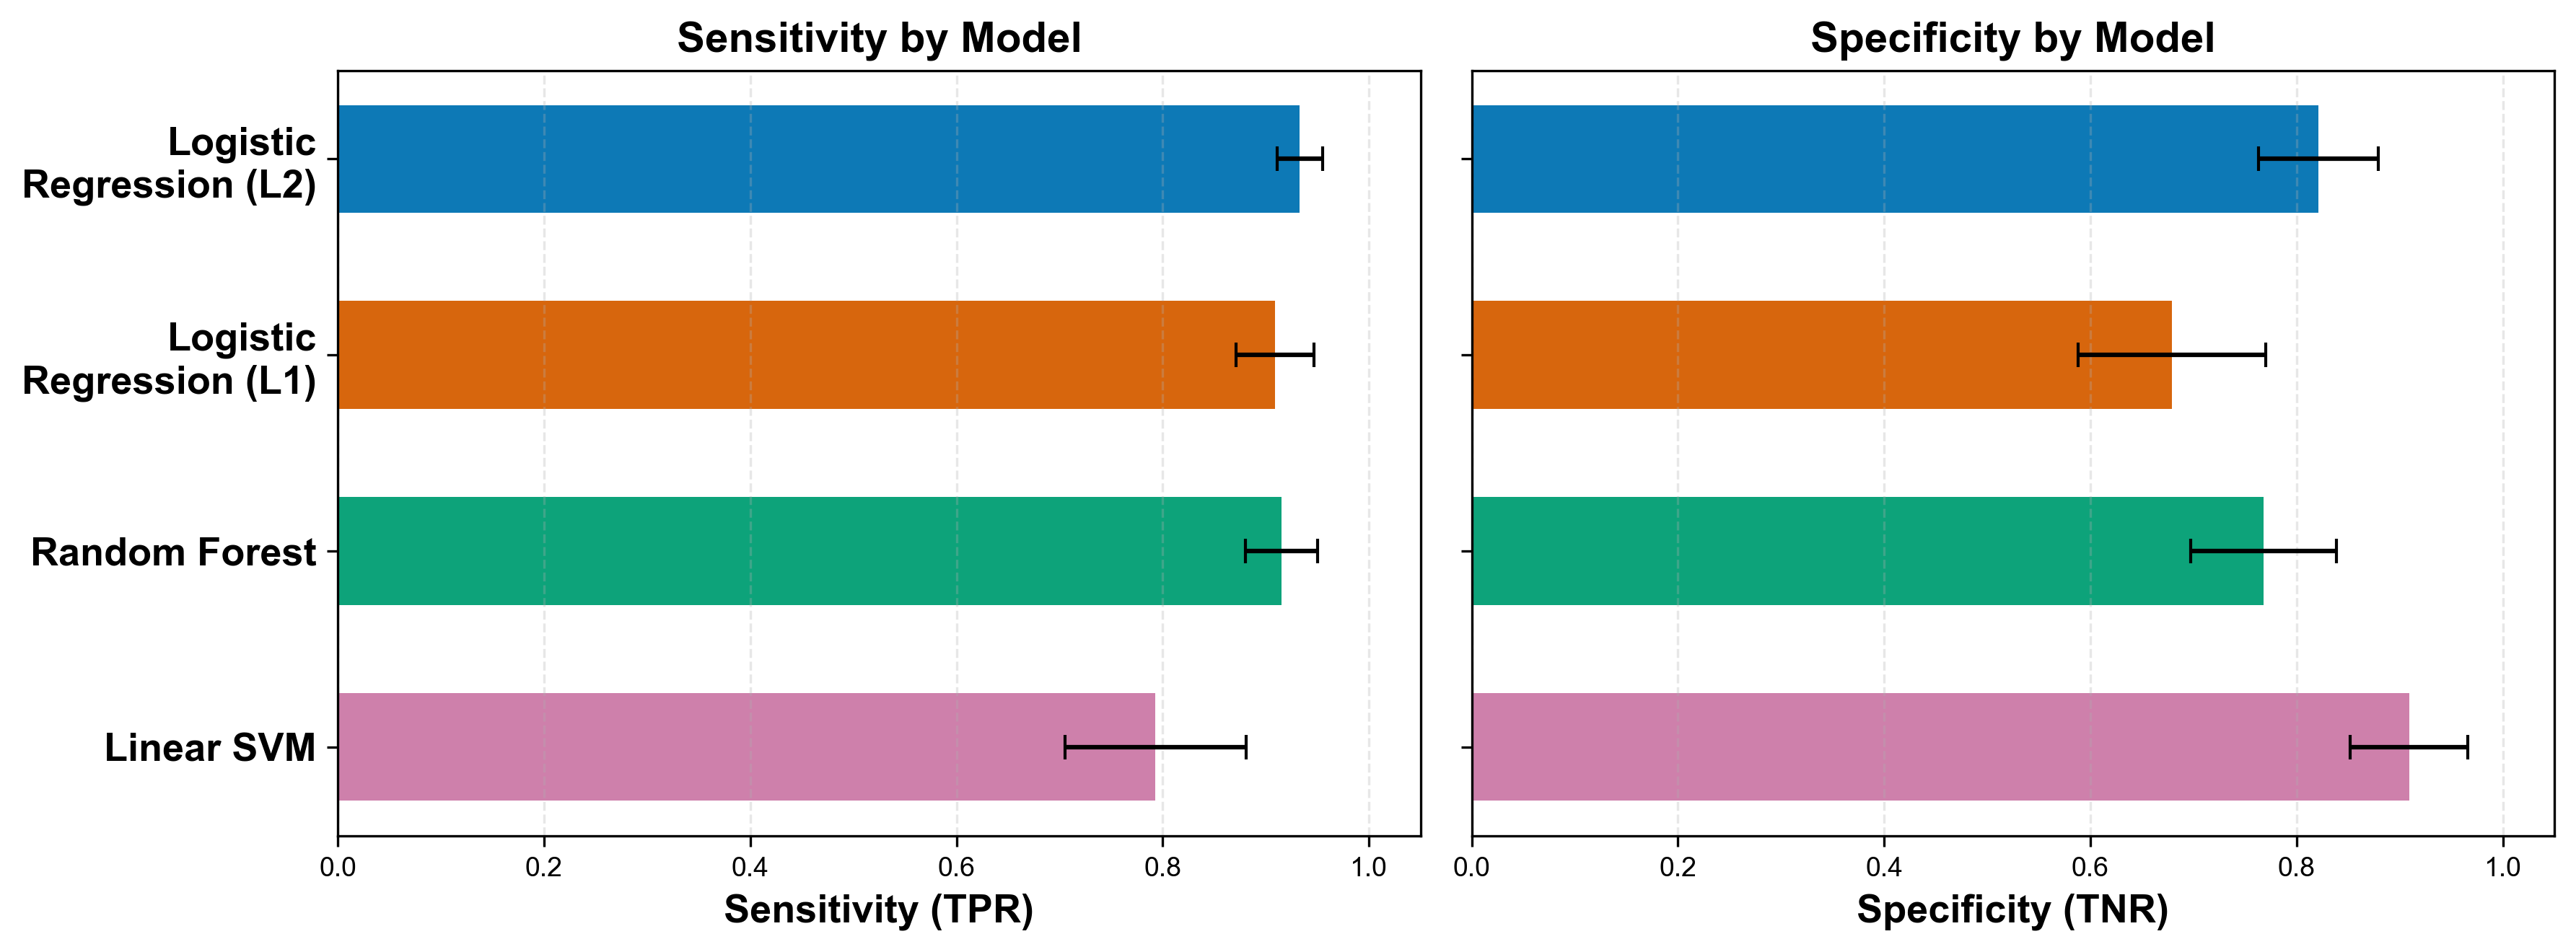

Saved: Figures/sens_spec_bars_colored.png


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_binary already exists from evaluate_binary

# Define consistent colors for each model
colors = {
    "Logistic Regression (L2)": "#0072B2",  # blue
    "Logistic Regression (L1)": "#D55E00",  # orange
    "Random Forest":            "#009E73",  # green
    "Linear SVM":               "#CC79A7",  # magenta
}

# Wrap model names into 2 lines for Logistic Regression
def wrap_name(name):
    if name.startswith("Logistic Regression"):
        parts = name.split(" ", 2)
        return f"{parts[0]}\n{parts[1]} {parts[2]}"
    else:
        return name

# Helper: parse "0.905 ± 0.022" -> (0.905, 0.022)
def parse_mean_std(s):
    if not isinstance(s, str):
        return np.nan, np.nan
    try:
        mean, std = s.split("±")
        return float(mean.strip()), float(std.strip())
    except:
        return np.nan, np.nan

# Extract arrays
raw_models = df_binary["Model"].tolist()
models = [wrap_name(m) for m in raw_models]

sens_means, sens_stds = [], []
spec_means, spec_stds = [], []

for _, row in df_binary.iterrows():
    sm, ss = parse_mean_std(row["Sensitivity"])
    pm, ps = parse_mean_std(row["Specificity"])
    sens_means.append(sm)
    sens_stds.append(ss)
    spec_means.append(pm)
    spec_stds.append(ps)

y_pos = np.arange(len(models))

# --- Create the figure ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# ========== Sensitivity Plot ==========
ax = axes[0]
for i, model in enumerate(raw_models):
    ax.barh(
        y_pos[i],
        sens_means[i],
        xerr=sens_stds[i],
        color=colors[model],
        alpha=0.95,
        ecolor="black",
        capsize=4,
        height=0.55,
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(models, fontsize=13, fontweight="bold")
ax.invert_yaxis()
ax.set_xlabel("Sensitivity (TPR)", fontsize=13, fontweight="bold")
ax.set_xlim(0, 1.05)
ax.set_title("Sensitivity by Model", fontsize=14, fontweight="bold")
ax.grid(axis='x', alpha=0.3, linestyle='--')

# ========== Specificity Plot ==========
ax = axes[1]
for i, model in enumerate(raw_models):
    ax.barh(
        y_pos[i],
        spec_means[i],
        xerr=spec_stds[i],
        color=colors[model],
        alpha=0.95,
        ecolor="black",
        capsize=4,
        height=0.55,
    )

ax.set_yticks(y_pos)
ax.set_yticklabels([], fontsize=13)
ax.invert_yaxis()
ax.set_xlabel("Specificity (TNR)", fontsize=13, fontweight="bold")
ax.set_xlim(0, 1.05)
ax.set_title("Specificity by Model", fontsize=14, fontweight="bold")
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig("Figures/sens_spec_bars_colored.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Figures/sens_spec_bars_colored.png")


### 4. Run multiclass classification

In [23]:
def evaluate_multiclass(X, y_multi, random_state=42):
    """Evaluate multiclass classification: CD vs UC vs Control using one CV run per model."""
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    models = {
        "Logistic Regression (L2)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l2",
                C=1.0,
                multi_class="multinomial",
                max_iter=3000,
                random_state=random_state
            )),
        ]),
        "Logistic Regression (L1)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l1",
                C=0.1,
                solver="saga",
                multi_class="multinomial",
                max_iter=5000,
                random_state=random_state
            )),
        ]),
        "Random Forest": RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_leaf=2,
            class_weight="balanced_subsample",
            random_state=random_state,
            n_jobs=-1
        ),
        "Linear SVM": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC(
                C=1.0,
                max_iter=5000,
                random_state=random_state
            )),
        ]),
    }

    print("\n" + "="*70)
    print("MULTICLASS CLASSIFICATION: CD vs UC vs Control")
    print("="*70)

    results = {'metrics': [], 'confusion_matrices': {}}

    X_np = np.asarray(X)
    y_np = np.asarray(y_multi)

    for name, model in models.items():
        print(f"\nEvaluating {name}...")

        fold_acc = []
        fold_bal_acc = []

        # out-of-fold predictions for confusion matrix
        oof_pred = np.empty(len(y_np), dtype=object)

        with tqdm(total=cv.get_n_splits(), desc=name, unit="fold") as pbar:
            for train_idx, test_idx in cv.split(X_np, y_np):
                m = clone(model)
                m.fit(X_np[train_idx], y_np[train_idx])

                y_pred = m.predict(X_np[test_idx])
                oof_pred[test_idx] = y_pred

                fold_acc.append(accuracy_score(y_np[test_idx], y_pred))
                fold_bal_acc.append(balanced_accuracy_score(y_np[test_idx], y_pred))

                pbar.update(1)

        acc_mean = np.mean(fold_acc)
        acc_std = np.std(fold_acc)
        bal_mean = np.mean(fold_bal_acc)
        bal_std = np.std(fold_bal_acc)

        results['metrics'].append({
            'Model': name,
            'Accuracy': f"{acc_mean:.3f} ± {acc_std:.3f}",
            'Balanced Acc': f"{bal_mean:.3f} ± {bal_std:.3f}"
        })

        cm = confusion_matrix(y_np, oof_pred, labels=['CD', 'Control', 'UC'])
        cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
        results['confusion_matrices'][name] = cm_norm

    return results


In [7]:
# Run multiclass classification (UC, CD, Control)
multi_results = evaluate_multiclass(X, y_multi, random_state=42)

df_multi = pd.DataFrame(multi_results['metrics'])
print("\n" + df_multi.to_string(index=False))

# Example: Access a confusion matrix
cm_l2 = multi_results['confusion_matrices']["Logistic Regression (L2)"]
print("\nNormalized Confusion Matrix (LogReg L2):")
print(cm_l2)



MULTICLASS CLASSIFICATION: CD vs UC vs Control

Evaluating Logistic Regression (L2)...


Logistic Regression (L2):   0%|          | 0/5 [00:00<?, ?fold/s]/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Logistic Regression (L2):  20%|██        | 1/5 [00:00<00:00,  4.08fold/s]/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Logistic Regression (L2):  40%|████      | 2/5 [00:00<00:00,  3.54fold/s]/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomi


Evaluating Logistic Regression (L1)...


Logistic Regression (L1):   0%|          | 0/5 [00:00<?, ?fold/s]/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Logistic Regression (L1):  20%|██        | 1/5 [00:37<02:31, 37.90s/fold]/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Logistic Regression (L1):  40%|████      | 2/5 [01:11<01:45, 35.28s/fold]/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomi


Evaluating Random Forest...


Random Forest: 100%|██████████| 5/5 [00:01<00:00,  2.65fold/s]



Evaluating Linear SVM...


Linear SVM: 100%|██████████| 5/5 [00:01<00:00,  4.79fold/s]


                   Model      Accuracy  Balanced Acc
Logistic Regression (L2) 0.695 ± 0.042 0.714 ± 0.038
Logistic Regression (L1) 0.718 ± 0.049 0.728 ± 0.056
           Random Forest 0.709 ± 0.056 0.718 ± 0.054
              Linear SVM 0.677 ± 0.044 0.701 ± 0.042

Normalized Confusion Matrix (LogReg L2):
[[0.67045455 0.09090909 0.23863636]
 [0.07142857 0.89285714 0.03571429]
 [0.30263158 0.11842105 0.57894737]]


### 4. Print results tables

In [8]:
# Binary classification results table
df_binary = pd.DataFrame(binary_results['metrics'])
print("\n" + "="*80)
print("Table 1: Binary Classification Performance (IBD vs Control) - 5-Fold CV")
print("="*80)
print(df_binary[['Model', 'Accuracy', 'Balanced Acc', 'ROC-AUC']].to_string(index=False))

# Multiclass classification results table
df_multi = pd.DataFrame(multi_results['metrics'])
print("\n" + "="*80)
print("Table 2: Multiclass Classification Performance (CD vs UC vs Control) - 5-Fold CV")
print("="*80)
print(df_multi[['Model', 'Accuracy', 'Balanced Acc']].to_string(index=False))


Table 1: Binary Classification Performance (IBD vs Control) - 5-Fold CV
                   Model      Accuracy  Balanced Acc       ROC-AUC
Logistic Regression (L2) 0.905 ± 0.022 0.877 ± 0.032 0.951 ± 0.027
Logistic Regression (L1) 0.850 ± 0.047 0.794 ± 0.060 0.929 ± 0.031
           Random Forest 0.877 ± 0.023 0.841 ± 0.031 0.948 ± 0.021
              Linear SVM 0.823 ± 0.066 0.851 ± 0.049           NaN

Table 2: Multiclass Classification Performance (CD vs UC vs Control) - 5-Fold CV
                   Model      Accuracy  Balanced Acc
Logistic Regression (L2) 0.695 ± 0.042 0.714 ± 0.038
Logistic Regression (L1) 0.718 ± 0.049 0.728 ± 0.056
           Random Forest 0.709 ± 0.056 0.718 ± 0.054
              Linear SVM 0.677 ± 0.044 0.701 ± 0.042


### 5. Visualization: ROC curves for binary classification

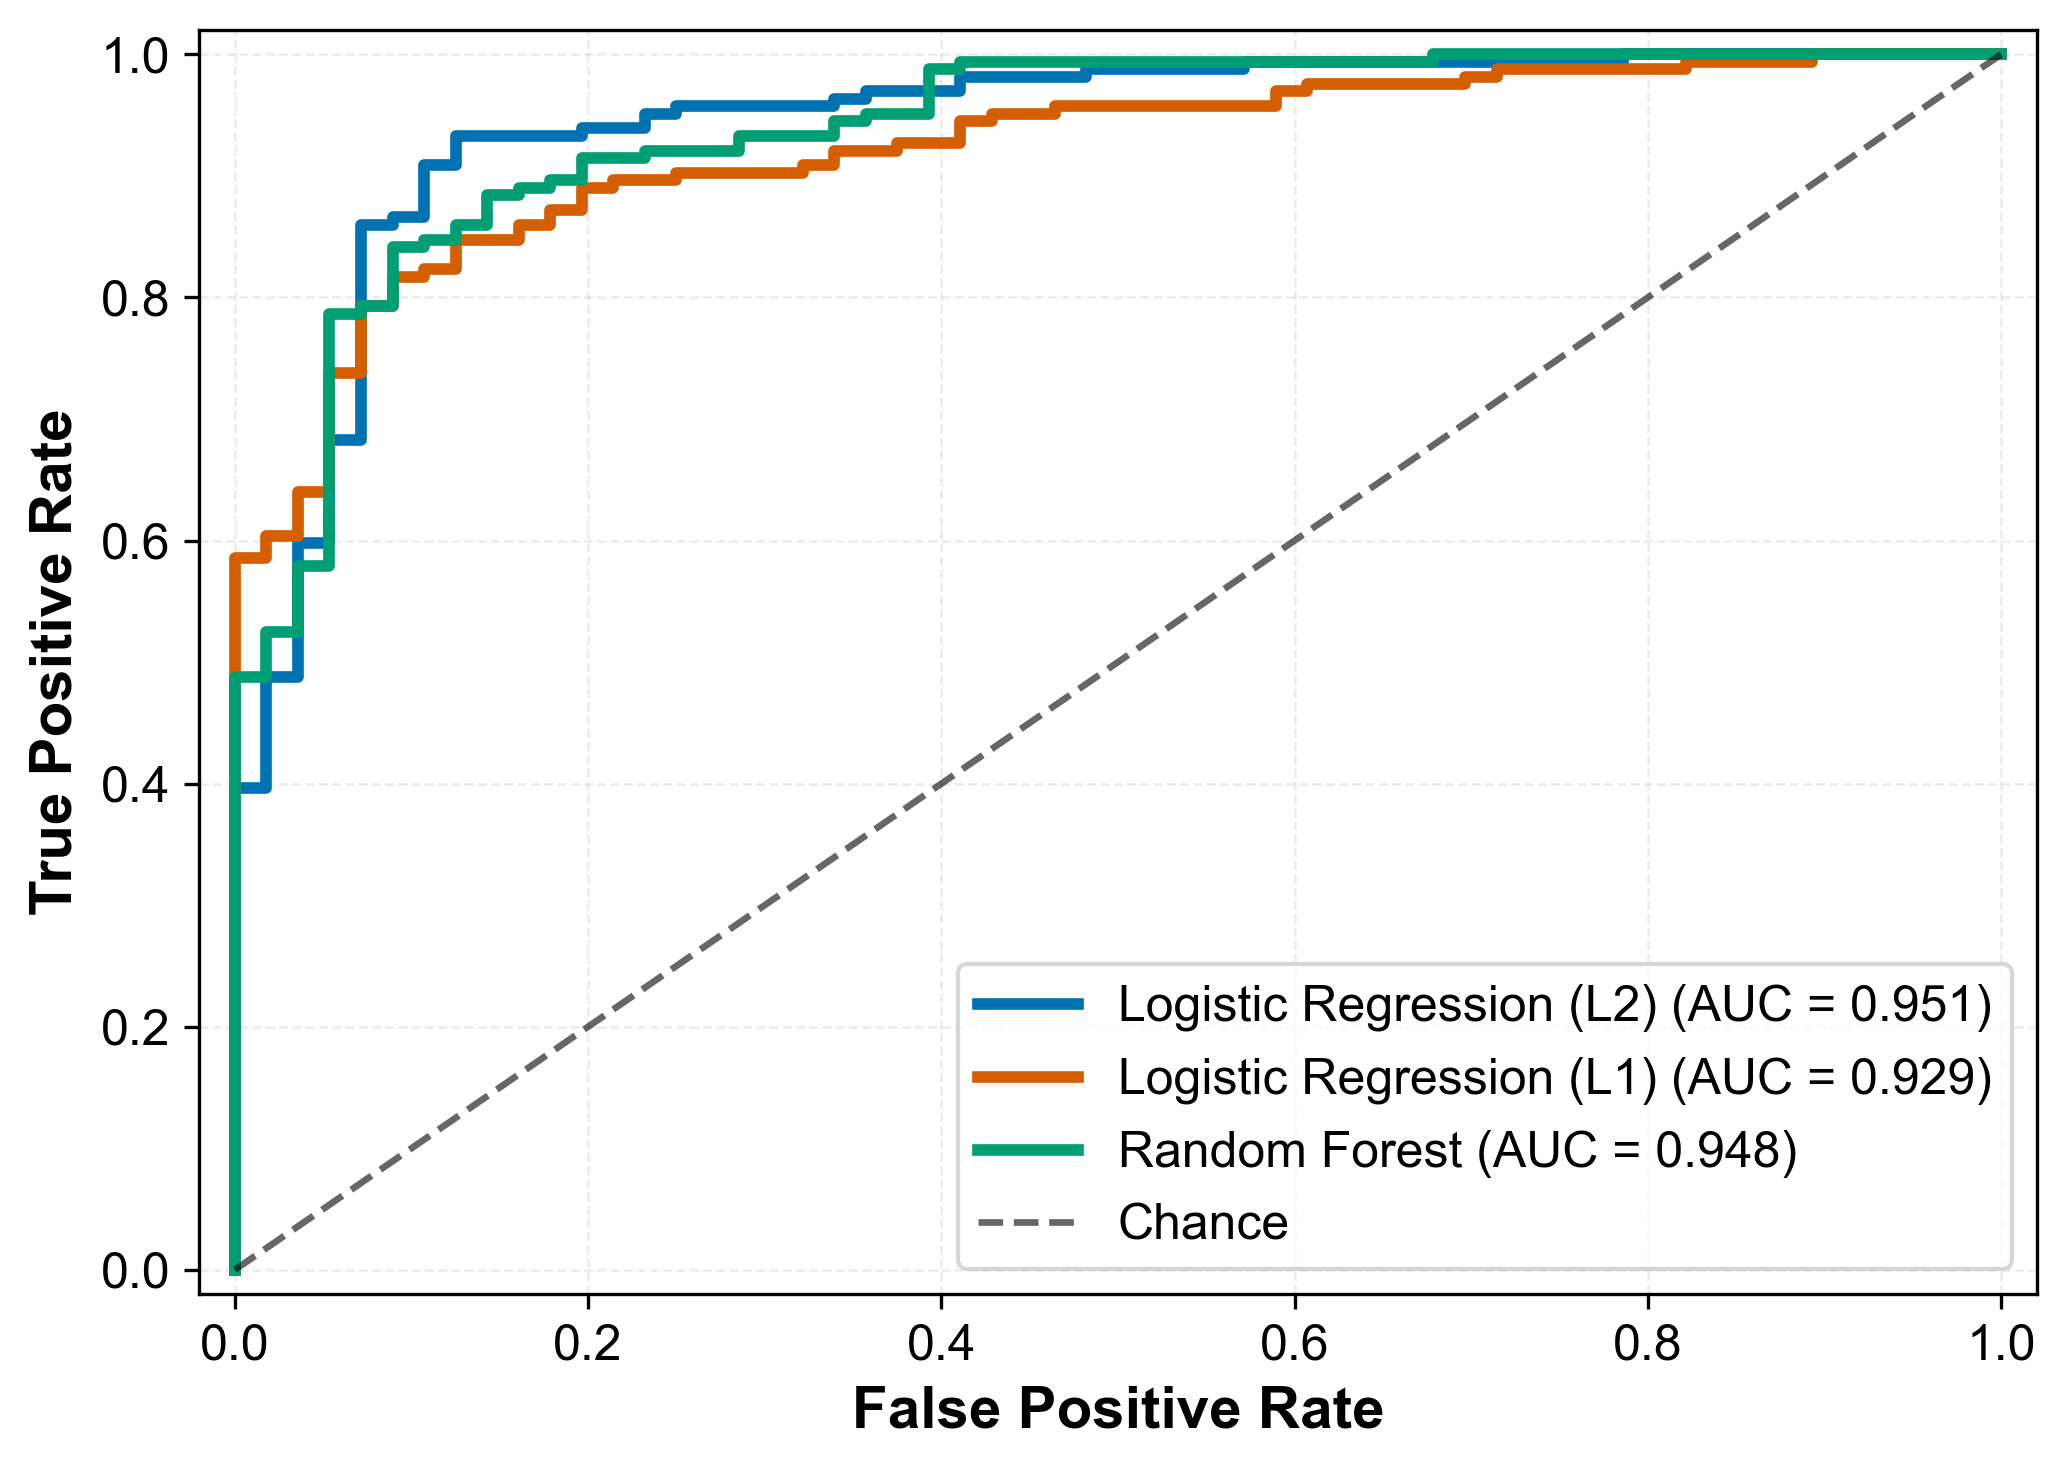

ROC saved as: roc_curves_binary_wide.png


In [15]:
# Plot ROC curves

fig, ax = plt.subplots(1, 1, figsize=(7, 5))   # wider figure

colors = ['#0072B2', '#D55E00', '#009E73']

for i, (model_name, roc_data) in enumerate(binary_results['roc_data'].items()):
    ax.plot(
        roc_data['fpr'], roc_data['tpr'],
        label=f"{model_name} (AUC = {roc_data['auc']:.3f})",
        color=colors[i],
        linewidth=2.8
    )

# Chance line
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.6, alpha=0.6, label="Chance")

# Formatting: slightly larger text everywhere
ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=14)
ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=14)

ax.tick_params(axis='both', labelsize=12)

# Legend larger and easier to read
ax.legend(
    loc='lower right',
    frameon=True,
    fancybox=True,
    fontsize=12
)

# Subtle grid
ax.grid(alpha=0.25, linestyle='--', linewidth=0.6)

# Limits
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.savefig('Figures/roc_curves_binary_wide.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC saved as: roc_curves_binary_wide.png")


### Precision - Recall curve

### 6. Visualization: Confusion matrices for multiclass classification

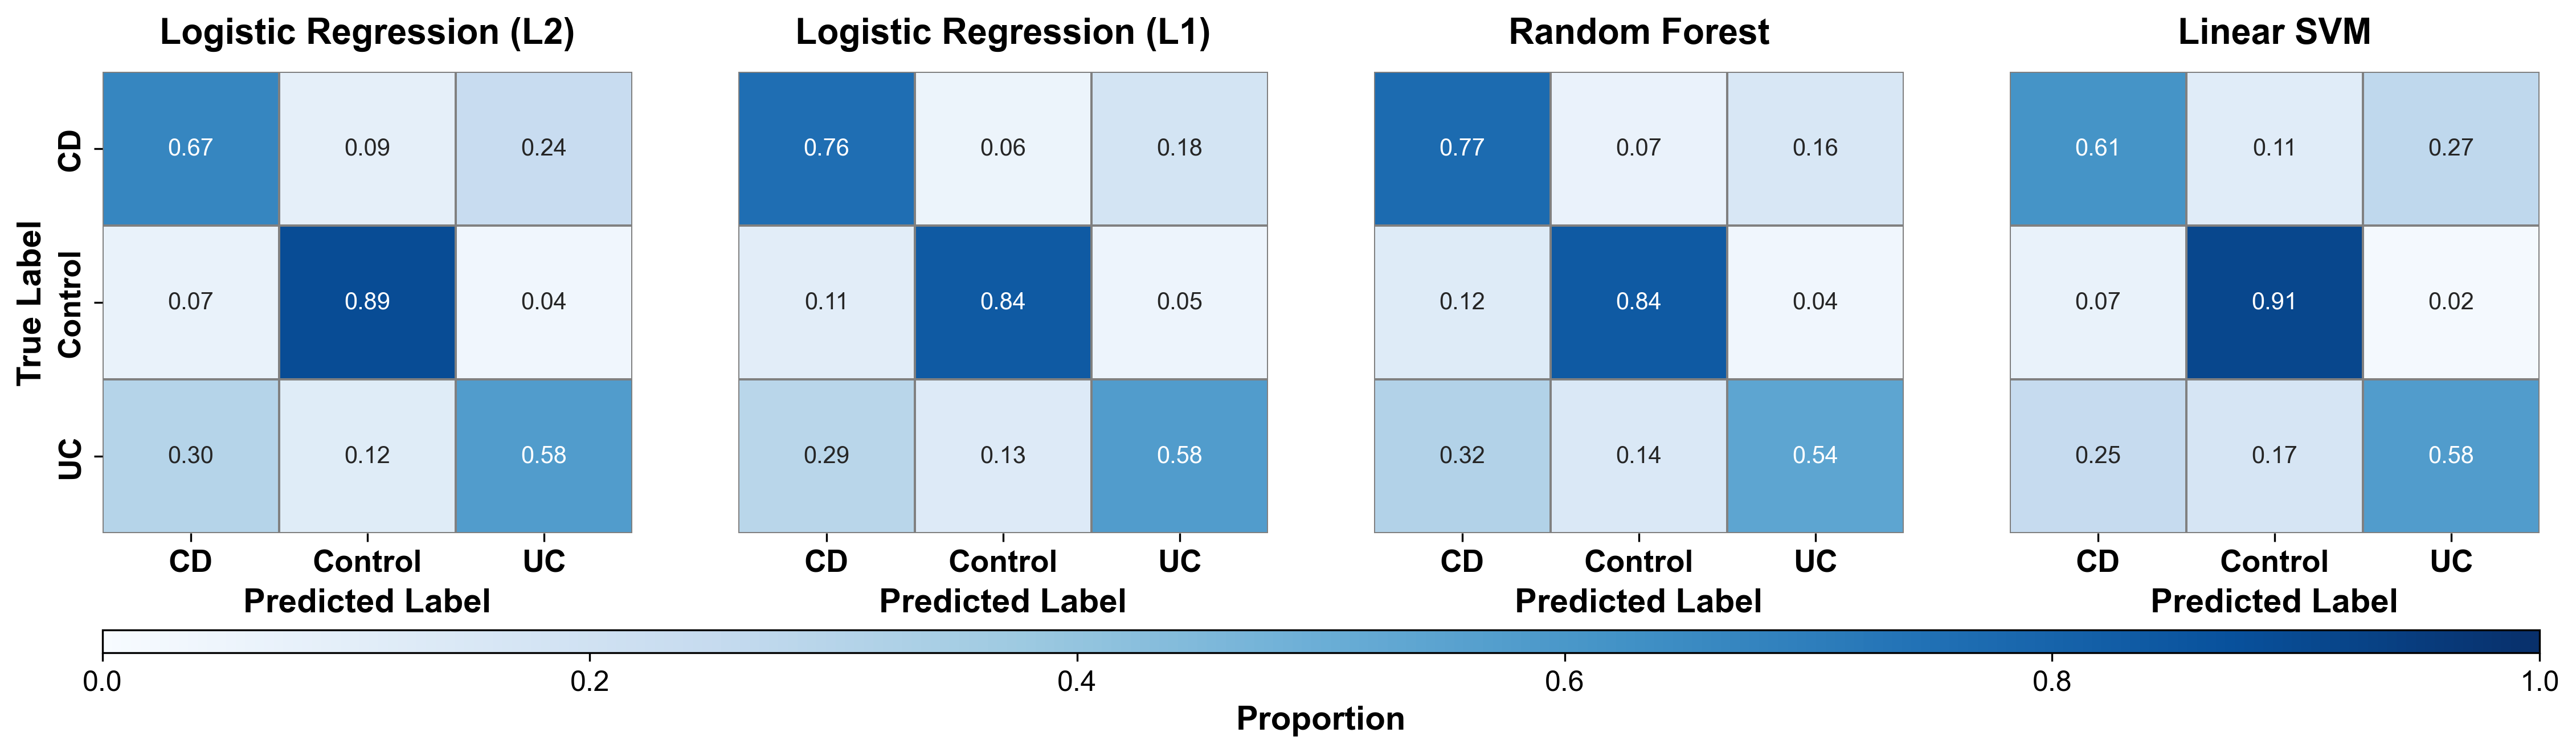

Saved: confusion_matrices_multiclass_bottom_cbar.png


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

cm_dict = multi_results['confusion_matrices']
n_models = len(cm_dict)

# ---- Create GridSpec: one row for matrices, one for colorbar ----
fig = plt.figure(figsize=(4.6 * n_models, 5.0))
gs = gridspec.GridSpec(
    nrows=2,
    ncols=n_models,
    height_ratios=[1, 0.05],   # top = matrices, bottom = colorbar
    hspace=0.40                # spacing between matrices and colorbar
)

axes = []
for i in range(n_models):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)

heatmap_artists = []

# ---- Plot each confusion matrix ----
for i, (ax, (model_name, cm_norm)) in enumerate(zip(axes, cm_dict.items())):
    
    hm = sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=['CD', 'Control', 'UC'],
        yticklabels=['CD', 'Control', 'UC'] if i == 0 else [],
        cbar=False,
        ax=ax,
        vmin=0, vmax=1,
        linewidths=0.5,
        linecolor='gray'
    )
    heatmap_artists.append(hm)

    # ---- Larger + bold tick labels ----
    ax.set_xticklabels(['CD', 'Control', 'UC'], fontsize=13, fontweight='bold')
    if i == 0:
        ax.set_yticklabels(['CD', 'Control', 'UC'], fontsize=13, fontweight='bold')

    # ---- Larger + bold model title ----
    ax.set_title(model_name, fontweight="bold", fontsize=15, pad=12)

    # ---- Axis labels, larger + bold ----
    ax.set_xlabel("Predicted Label", fontweight="bold", fontsize=14)
    if i == 0:
        ax.set_ylabel("True Label", fontweight="bold", fontsize=14)
    else:
        ax.set_ylabel("")

    ax.tick_params(labelsize=13)

# ---- Shared bottom colorbar ----
cbar_ax = fig.add_subplot(gs[1, :])
mappable = heatmap_artists[-1].collections[0]
cbar = fig.colorbar(
    mappable,
    cax=cbar_ax,
    orientation="horizontal"
)
cbar.set_label("Proportion", fontsize=14, fontweight="bold")
cbar.ax.tick_params(labelsize=12)

# ---- Move colorbar slightly further down (~0.1 cm) ----
fig.subplots_adjust(bottom=0.20)   # tweak if needed: 0.18–0.22

# ---- Save ----
fig.savefig(
    "Figures/confusion_matrices_multiclass_bottom_cbar.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved: confusion_matrices_multiclass_bottom_cbar.png")


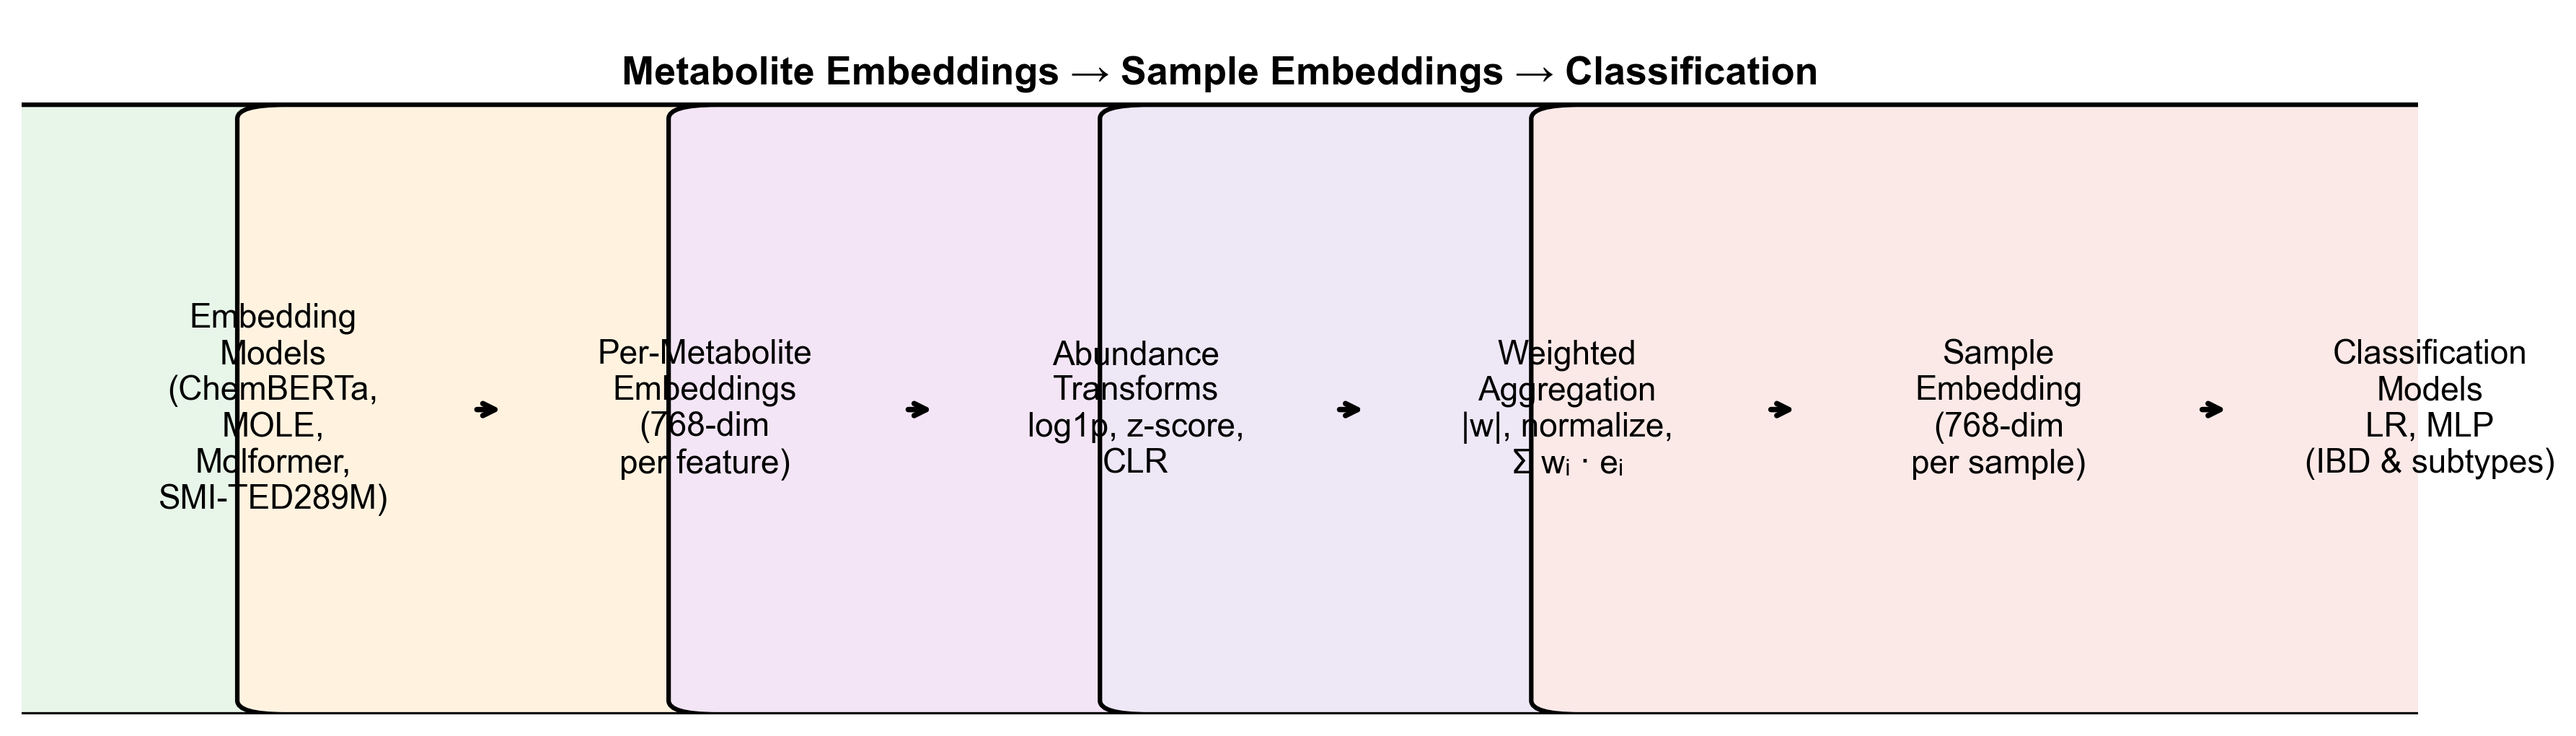

Saved: diagram_embedding_pipeline_horizontal.png


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Helper to draw a rounded box
def draw_box(ax, xy, width, height, text, facecolor="#F5F5F5",
             fontsize=11, lw=1.5):
    rect = FancyBboxPatch(
        xy, width, height,
        boxstyle="round,pad=0.3,rounding_size=0.02",
        edgecolor="black",
        linewidth=lw,
        facecolor=facecolor
    )
    ax.add_patch(rect)
    ax.text(
        xy[0] + width / 2,
        xy[1] + height / 2,
        text,
        ha="center",
        va="center",
        fontsize=fontsize
    )

fig, ax = plt.subplots(figsize=(12, 3.5))
ax.axis("off")

# Common geometry
y = 0.3         # vertical position of boxes
width = 0.15
height = 0.28
gap = 0.03

# X positions for 6 steps
xs = [0.03 + i*(width + gap) for i in range(6)]

# Nice pastel colors per stage
colors = [
    "#e3f2fd",  # light blue
    "#e8f5e9",  # light green
    "#fff3e0",  # light orange
    "#f3e5f5",  # light purple
    "#ede7f6",  # light indigo
    "#fbe9e7",  # light coral
]

# Step texts (short titles + subtitles)
texts = [
    "Embedding\nModels\n(ChemBERTa,\nMOLE,\nMolformer,\nSMI-TED289M)",
    "Per-Metabolite\nEmbeddings\n(768-dim\nper feature)",
    "Abundance\nTransforms\nlog1p, z-score,\nCLR",
    "Weighted\nAggregation\n|w|, normalize,\nΣ wᵢ · eᵢ",
    "Sample\nEmbedding\n(768-dim\nper sample)",
    "Classification\nModels\nLR, MLP\n(IBD & subtypes)",
]

# Draw boxes
for x, txt, col in zip(xs, texts, colors):
    draw_box(ax, (x, y), width, height, txt, facecolor=col, fontsize=11)

# Draw arrows between box centers
for i in range(len(xs) - 1):
    x_start = xs[i] + width
    x_end = xs[i+1]
    ax.annotate(
        "",
        xy=(x_end - 0.01, y + height/2),
        xytext=(x_start + 0.01, y + height/2),
        arrowprops=dict(
            arrowstyle="->",
            linewidth=1.8,
            shrinkA=0,
            shrinkB=0
        )
    )

# Optional global title (remove if you prefer slide title only)
ax.text(
    0.5, 0.95,
    "Metabolite Embeddings → Sample Embeddings → Classification",
    ha="center", va="top",
    fontsize=13, fontweight="bold"
)

plt.tight_layout()
plt.savefig("diagram_embedding_pipeline_horizontal.png",
            dpi=300, bbox_inches="tight")
plt.show()

print("Saved: diagram_embedding_pipeline_horizontal.png")
